In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from einops import rearrange
from lpdm.nn.autoencoder import Decoder, Encoder
from lpdm.nn.common import LayerNorm
from the_well.benchmark.data import WellDataModule
from the_well.benchmark.metrics.spectral import power_spectrum
from torch import Tensor

## Data

In [2]:
data_module = WellDataModule(
    well_base_path="/mnt/home/polymathic/ceph/the_well",
    well_dataset_name="euler_multi_quadrants_openBC",
    batch_size=4,
    n_steps_input=1,
    n_steps_output=1,
    data_workers=8,
    include_filters=["365_Dry_air"],
)

metadata = data_module.train_dataset._build_metadata()

## Autoencoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder(5, 16, hid_channels=(64, 128, 256, 384), hid_blocks=(1, 1, 1, 1))
        self.decoder = Decoder(16, 5, hid_channels=(384, 256, 128, 64), hid_blocks=(1, 1, 1, 1))
        self.norm = LayerNorm(dim=1)

    def encode(self, x: Tensor) -> Tensor:
        z = self.encoder(x)
        z = self.norm(z)
        return z

    def decode(self, z: Tensor) -> Tensor:
        return self.decoder(z)

    def loss(self, x: Tensor) -> Tensor:
        y = self.decode(self.encode(x))
        return (x - y).square().mean()

## Training

In [4]:
model = AutoEncoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)

In [5]:
def safe_sgd_step(loss: Tensor, clip: float = 1.0) -> Tensor:
    if loss.isfinite().all():
        loss.backward()
        norm = nn.utils.clip_grad_norm_(model.parameters(), clip)
        if norm.isfinite():
            optimizer.step()
            optimizer.zero_grad()

    return loss.detach()

In [6]:
# loader = data_module.train_dataloader()

# for batch in (bar := tqdm(loader, ncols=88, miniters=1)):
#     x = batch["input_fields"][:, 0]
#     x = rearrange(x, "B H W C -> B C H W")  # TODO: log-energy and log-density
#     x = x.cuda(non_blocking=True)

#     l = model.loss(x)
#     l = safe_sgd_step(l, clip=1.0)

#     bar.set_postfix(loss=l.item())

# torch.save(model.state_dict(), "checkpoint.pkl")

## Evaluation

In [7]:
model.load_state_dict(torch.load("checkpoint.pkl"))

<All keys matched successfully>

In [8]:
loader = data_module.val_dataloader()

for batch in loader:
    x = batch["input_fields"][:, 0]
    x = rearrange(x, "B H W C -> B C H W")
    x = x.cuda()
    break

with torch.no_grad():
    z = model.encode(x)
    y = model.decode(z)

x = x.detach().cpu()
y = y.detach().cpu()

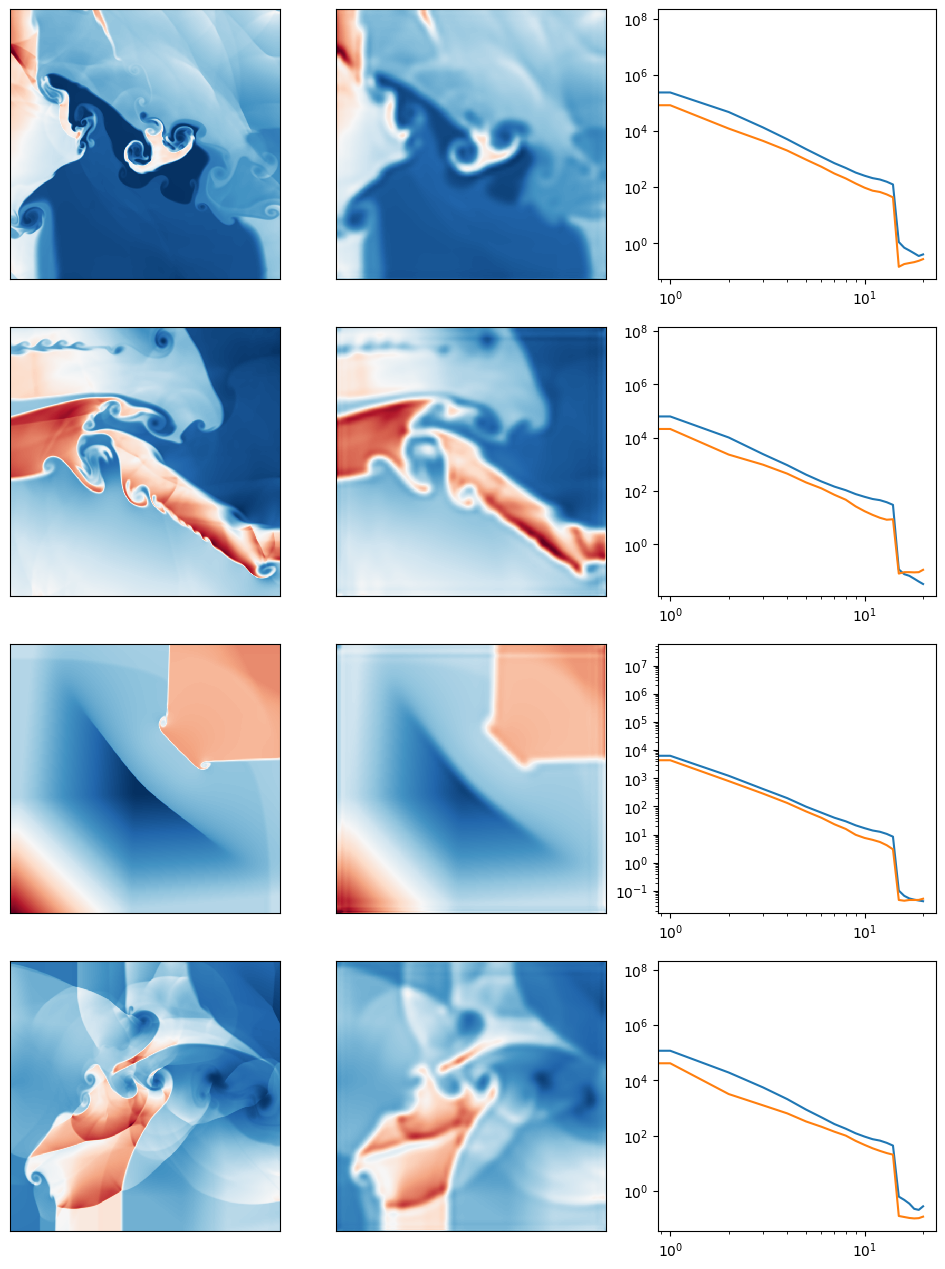

In [9]:
field = 1
fig, axs = plt.subplots(4, 3, figsize=(9.6, 12.8))

for i in range(4):
    vmin = np.nanmin(x[i, field])
    vmax = np.nanmax(x[i, field])

    axs[i, 0].imshow(x[i, field], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])

    axs[i, 1].imshow(y[i, field], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])

    bins, x_ps_mean, x_ps_std = power_spectrum(rearrange(x[i], "C H W -> H W C"), meta=metadata)
    bins, y_ps_mean, y_ps_std = power_spectrum(rearrange(y[i], "C H W -> H W C"), meta=metadata)

    axs[i, 2].loglog(x_ps_mean[:, field])
    axs[i, 2].loglog(y_ps_mean[:, field])

plt.tight_layout()